<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Les-librairies-nécessaires" data-toc-modified-id="Les-librairies-nécessaires-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Les librairies nécessaires</a></span></li><li><span><a href="#La-connexion-à-la-base-de-données-PostgreSQL" data-toc-modified-id="La-connexion-à-la-base-de-données-PostgreSQL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>La connexion à la base de données PostgreSQL</a></span></li><li><span><a href="#Création-de-la-table-COMMANDES01" data-toc-modified-id="Création-de-la-table-COMMANDES01-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Création de la table COMMANDES01</a></span><ul class="toc-item"><li><span><a href="#Clé-primaire-pour-la-table-COMMANDES01" data-toc-modified-id="Clé-primaire-pour-la-table-COMMANDES01-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Clé primaire pour la table COMMANDES01</a></span></li><li><span><a href="#Clé-étrangère-référencent-la-colonne-NO_EMPLOYE-de-la-table-EMPLOYES" data-toc-modified-id="Clé-étrangère-référencent-la-colonne-NO_EMPLOYE-de-la-table-EMPLOYES-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Clé étrangère référencent la colonne NO_EMPLOYE de la table EMPLOYES</a></span></li></ul></li></ul></div>

# Les librairies nécessaires

In [1]:
import pandas as pd, numpy as np, seaborn as sns
import warnings 
import os
from matplotlib import pyplot as plt

from datetime import datetime
warnings.filterwarnings(action="ignore")

%matplotlib inline

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=3)

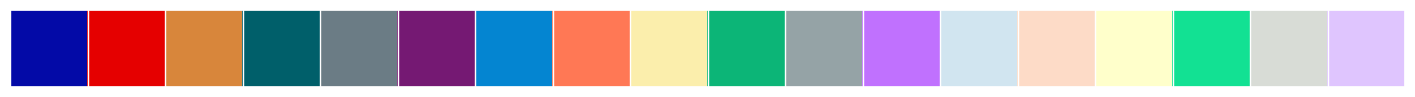

In [2]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [74]:
def afficheDendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# Lecture du fichier de données

In [3]:
donnees=pd.read_parquet('../donnees/export_sql.parquet')
donnees.head()

,pays,province,annee,mois,fournisseur,categorie,quantites,port,ca
0,Espagne,Girona,2019,10,Exotic Liquids,Boissons,350,313.600006,18371.162109
1,Espagne,Girona,2019,10,Heli Süßwaren GmbH Co. KG,Desserts,296,306.399994,14257.975586
2,Espagne,Girona,2019,10,Lyngbysild,Poissons et fruits de mer,346,306.399994,18075.441406
3,Australie,Queensland,2019,11,Formaggi Fortini s.r.l.,Boissons,306,237.100006,12905.174805
4,Australie,New South Wales,2019,11,Bigfoot Breweries,Boissons,857,660.200012,33213.148438


In [5]:
donnees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75120 entries, 0 to 75119
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pays         75120 non-null  object 
 1   province     75120 non-null  object 
 2   annee        75120 non-null  int64  
 3   mois         75120 non-null  int64  
 4   fournisseur  75120 non-null  object 
 5   categorie    75120 non-null  object 
 6   quantites    75120 non-null  int64  
 7   port         75120 non-null  float32
 8   ca           75120 non-null  float32
dtypes: float32(2), int64(3), object(4)
memory usage: 4.6+ MB


In [6]:
donnees.describe()

,annee,mois,quantites,port,ca
count,75120.000000,75120.000000,75120.000000,75120.000000,75120.000000
mean,2017.945261,6.539776,295.768118,202.553268,17483.455078
std,0.791474,3.432156,264.056237,172.021469,16382.692383
min,2017.000000,1.000000,20.000000,50.000000,610.768005
25%,2017.000000,4.000000,125.000000,85.000000,6812.140747
50%,2018.000000,7.000000,211.000000,153.199997,12445.887695
75%,2019.000000,10.000000,382.000000,255.600006,22638.795898
max,2019.000000,12.000000,3990.000000,2572.800049,240960.593750


In [7]:
donnees.columns

Index(['pays', 'province', 'annee', 'mois', 'fournisseur', 'categorie',
       'quantites', 'port', 'ca'],
      dtype='object')

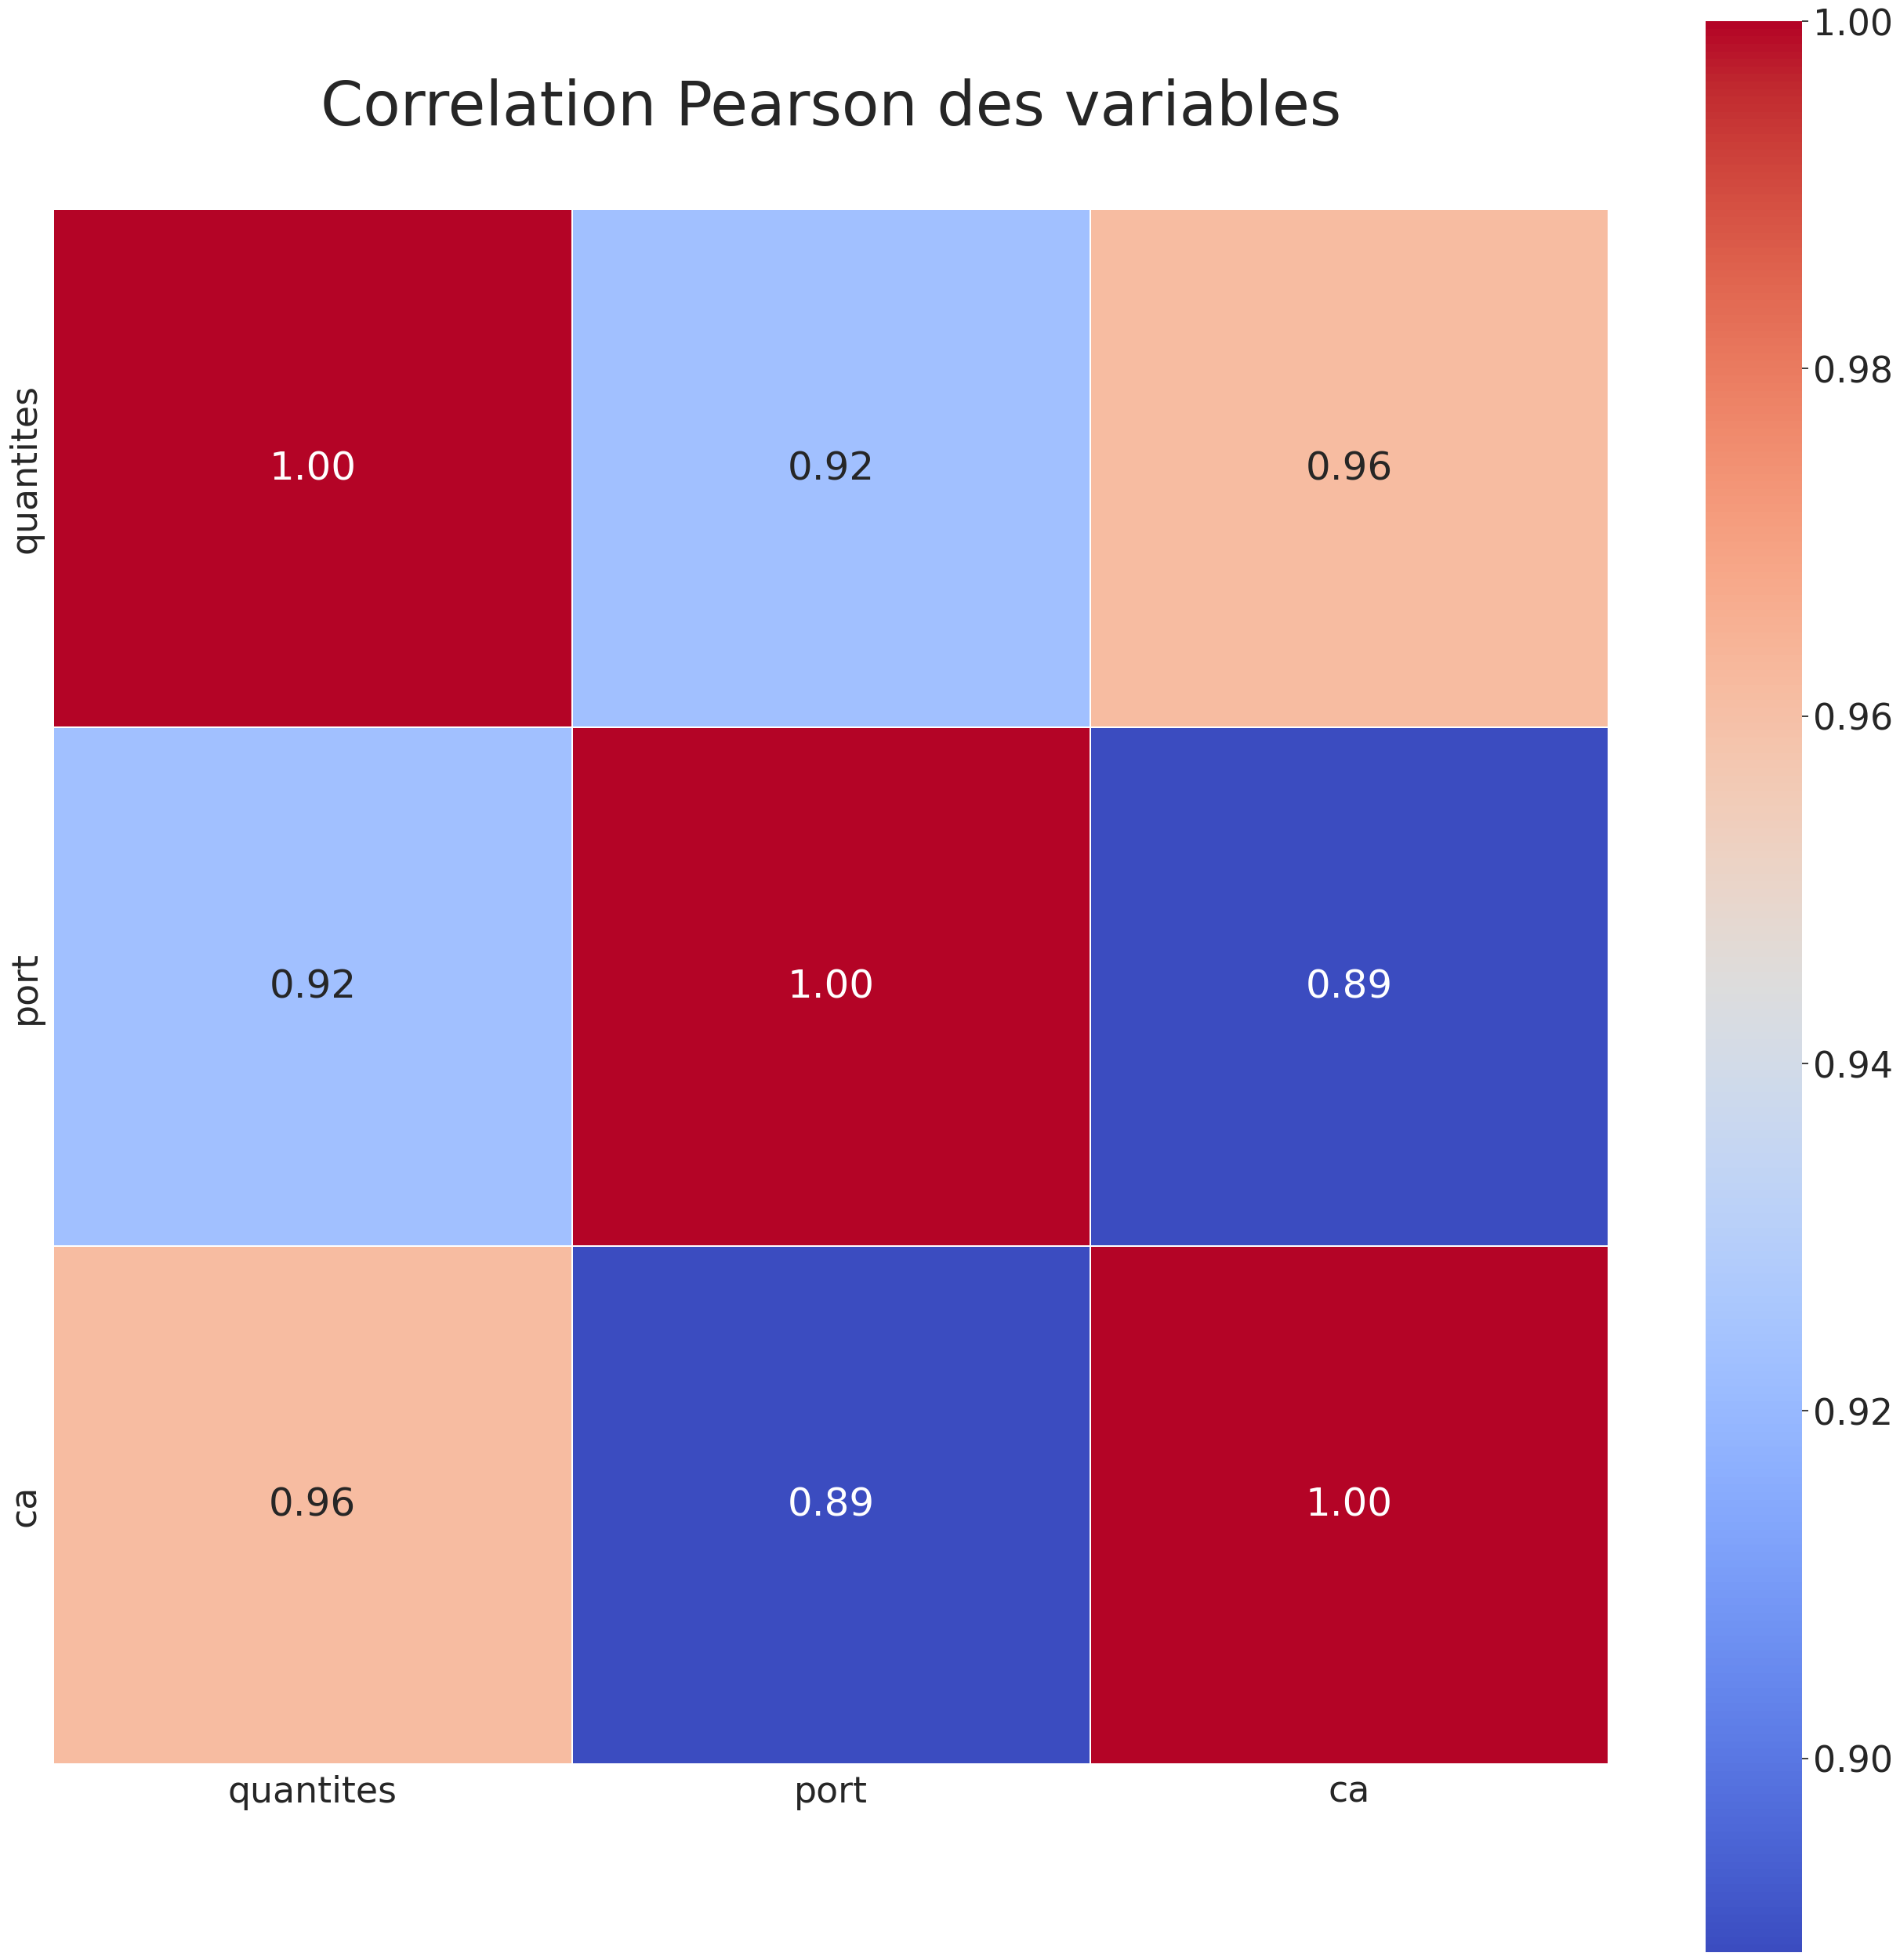

In [33]:
plt.figure(figsize=(32,32))
plt.title('Correlation Pearson des variables', y=1.05, size=56)
sns.heatmap(donnees[['quantites', 'port', 'ca']].corr(),linewidths=0.3,vmax=1.0, fmt= '.2f', 
            square=True, cmap='coolwarm', linecolor='white', annot=True);

In [34]:
donnees.columns

Index(['pays', 'province', 'annee', 'mois', 'fournisseur', 'categorie',
       'quantites', 'port', 'ca'],
      dtype='object')

In [47]:
tc = donnees.pivot_table(index=['fournisseur','categorie'],
                    columns=['pays'], 
                    values='quantites')

In [50]:
tc.head()

pays                                           Allemagne   Australie  \
fournisseur                categorie                                   
Aux joyeux ecclésiastiques Boissons           585.358974  754.079365   
                           Produits laitiers  253.025641  261.283019   
                           Pâtes et céréales  238.810606  292.653061   
Bigfoot Breweries          Boissons           697.018405  969.582090   
                           Condiments         414.164384  534.100000   

pays                                              Brésil      Canada  \
fournisseur                categorie                                   
Aux joyeux ecclésiastiques Boissons           536.951613  494.062500   
                           Produits laitiers  243.081633  228.833333   
                           Pâtes et céréales  236.085106  188.750000   
Bigfoot Breweries          Boissons           681.907692  671.303030   
                           Condiments         377.316667  357.833333   

pays                                            Danemark     Espagne  \
fournisseur                categorie                                   
Aux joyeux ecclésiastiques Boissons           414.700000  435.566038   
                           Produits laitiers  157.428571  197.973684   
                           Pâtes et céréales  205.695652  192.970588   
Bigfoot Breweries          Boissons           369.787879  499.196429   
                           Condiments         289.750000  315.043478   

pays                                              France      Italie  \
fournisseur                categorie                                   
Aux joyeux ecclésiastiques Boissons           393.155738  508.755556   
                           Produits laitiers  180.266667  239.007246   
                           Pâtes et céréales  189.616279  207.680272   
Bigfoot Breweries          Boissons           512.540323  645.523316   
                           Condiments         326.170000  361.148571   

pays                                               Japon  Royaume-Uni  \
fournisseur                categorie                                    
Aux joyeux ecclésiastiques Boissons           663.750000   515.209677   
                           Produits laitiers  290.884615   187.140000   
                           Pâtes et céréales  246.483871   235.045455   
Bigfoot Breweries          Boissons           758.000000   620.046875   
                           Condiments         385.500000   366.862069   

pays                                           Singapour  États-Unis  
fournisseur                categorie                                  
Aux joyeux ecclésiastiques Boissons           400.379310  477.916388  
                           Produits laitiers  182.111111  206.632558  
                           Pâtes et céréales  208.619048  211.035714  
Bigfoot Breweries          Boissons           405.931034  590.984026  
                           Condiments         243.440000  338.097473

<Axes: title={'center': 'Correlation Pearson des variables'}, xlabel='pays', ylabel='pays'>

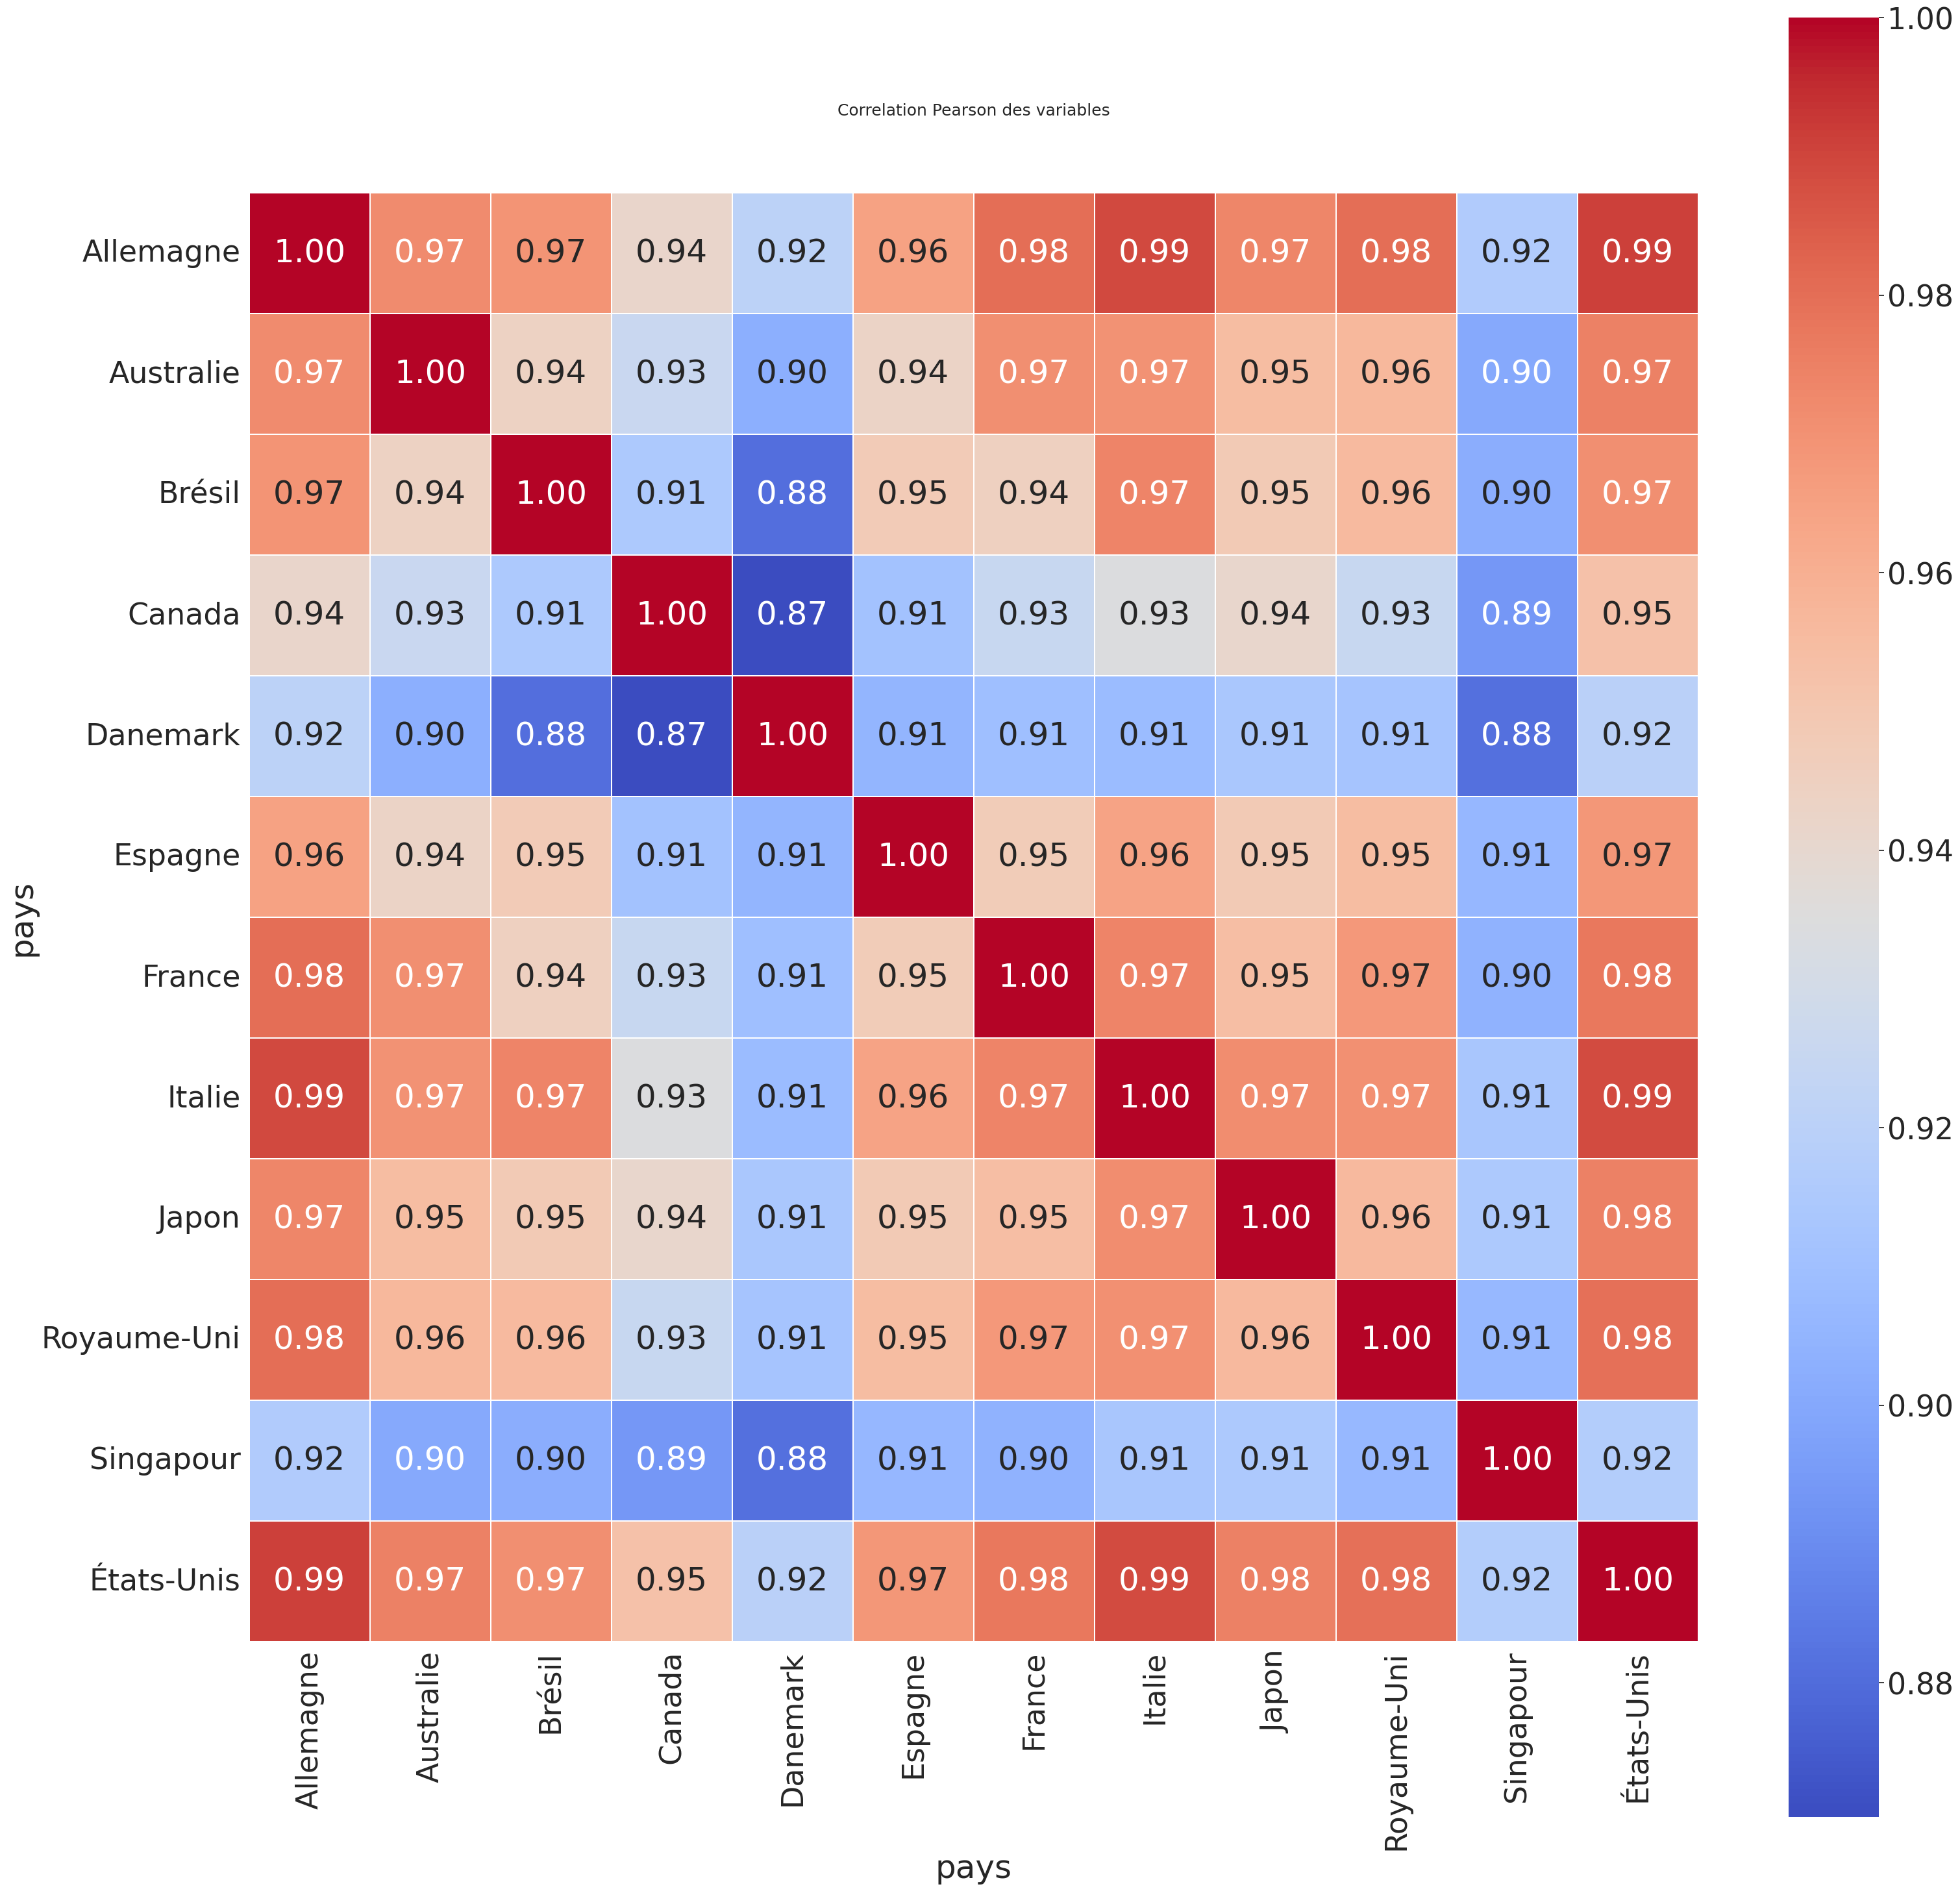

In [49]:
plt.figure(figsize=(36,36))
plt.title('Correlation Pearson des variables', y=1.05, size=18)
sns.heatmap(tc.corr(),linewidths=0.3,vmax=1.0, fmt= '.2f', 
            square=True, cmap='coolwarm', linecolor='white', annot=True)

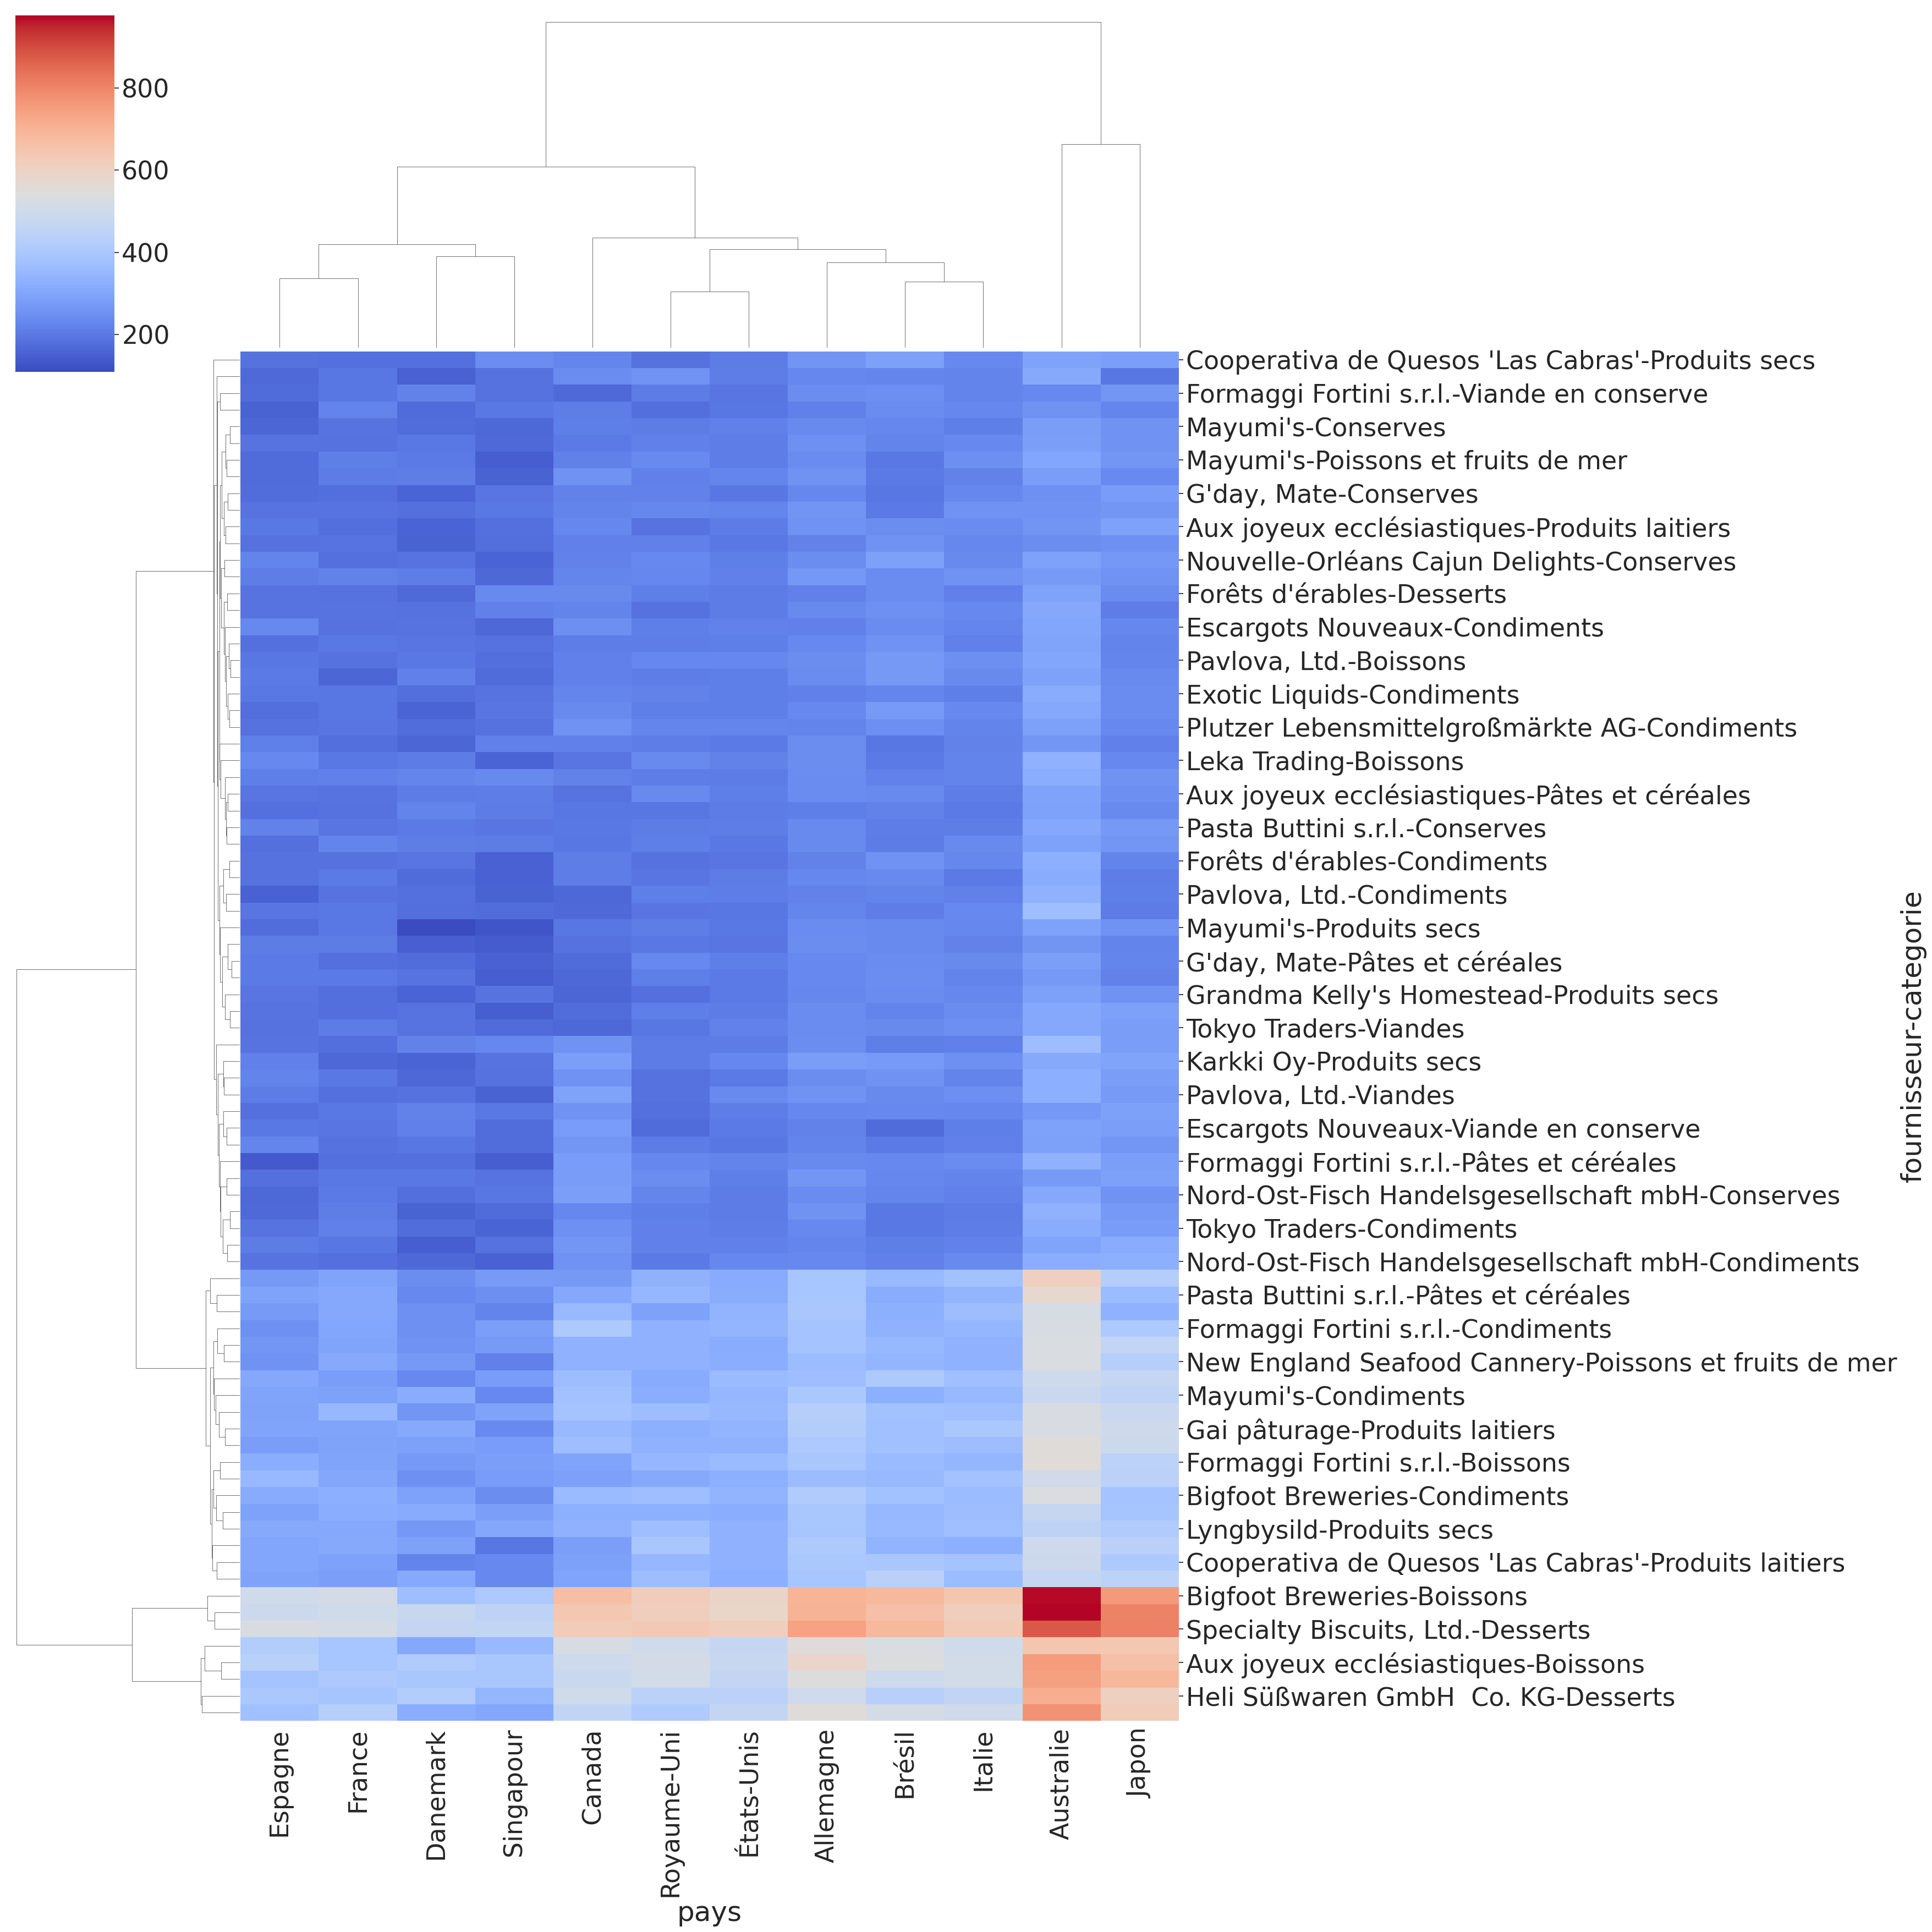

In [52]:
sns.clustermap(tc,cmap='coolwarm', figsize=(36,36));

In [59]:
d01 = donnees.pivot_table(index=['pays'],
                    columns=['fournisseur','categorie', 'annee'], 
                    values='quantites')
d01

fournisseur Aux joyeux ecclésiastiques                          \
categorie                     Boissons                           
annee                             2017        2018        2019   
pays                                                             
Allemagne                   616.423077  689.929825  424.170213   
Australie                   757.863636  927.000000  549.473684   
Brésil                      559.578947  584.541667  454.210526   
Canada                      494.454545  555.666667  411.444444   
Danemark                    474.200000  371.272727  401.666667   
Espagne                     482.600000  532.105263  237.357143   
France                      450.384615  402.851064  318.500000   
Italie                      609.789474  547.328125  369.305085   
Japon                       508.500000  934.250000  548.500000   
Royaume-Uni                 491.500000  585.666667  467.333333   
Singapour                   382.909091  447.800000  365.125000   
États-Unis                  528.076923  511.558559  371.357143   

fournisseur                                                              \
categorie   Produits laitiers                         Pâtes et céréales   
annee                    2017        2018        2019              2017   
pays                                                                      
Allemagne          305.950000  256.562500  174.172414        269.895833   
Australie          237.055556  294.882353  253.777778        254.625000   
Brésil             274.800000  218.250000  244.571429        257.687500   
Canada             184.777778  356.250000  139.857143        200.000000   
Danemark           156.333333  128.166667  188.333333        299.222222   
Espagne            224.428571  211.000000  125.625000        208.230769   
France             223.107143  172.935484  119.500000        188.187500   
Italie             242.723404  290.641509  162.394737        212.708333   
Japon              242.500000  357.200000  256.375000        217.100000   
Royaume-Uni        243.000000  195.176471  111.000000        225.000000   
Singapour          188.500000  194.875000  147.000000        219.875000   
États-Unis         203.265823  253.152778  158.453125        222.910256   

fournisseur                         Bigfoot Breweries  ...  \
categorie                                    Boissons  ...   
annee              2018        2019              2017  ...   
pays                                                   ...   
Allemagne    253.250000  178.111111        755.851852  ...   
Australie    343.315789  267.357143       1028.227273  ...   
Brésil       232.722222  214.153846        672.857143  ...   
Canada       172.909091  205.600000        688.750000  ...   
Danemark     183.428571  107.714286        465.909091  ...   
Espagne      227.636364  135.000000        541.631579  ...   
France       207.428571  159.210526        523.738095  ...   
Italie       238.277778  165.600000        703.258065  ...   
Japon        279.083333  235.666667        721.750000  ...   
Royaume-Uni  305.785714  181.937500        534.500000  ...   
Singapour    195.500000  211.600000        456.700000  ...   
États-Unis   229.195402  168.559322        657.915888  ...   

fournisseur             Tokyo Traders                                        \
categorie   Poissons et fruits de mer Produits secs                           
annee                            2019          2017        2018        2019   
pays                                                                          
Allemagne                  235.062500    397.187500  479.472727  287.837209   
Australie                  183.818182    455.826087  671.818182  423.333333   
Brésil                     179.666667    331.388889  323.954545  331.588235   
Canada                     249.285714    376.600000  369.333333  309.666667   
Danemark                   184.500000    228.444444  293.111111  229.333333   
Espagne                    172.100000 

In [60]:
from sklearn.preprocessing import StandardScaler
modelStd = StandardScaler()
modelStd.fit(d01.values)
x = modelStd.transform(d01.values)

In [61]:
from sklearn.decomposition import PCA
pca = PCA()
model = pca.fit(x)

In [62]:
pca.explained_variance_ratio_.cumsum()*100

array([ 51.47294655,  61.49187397,  69.35327719,  76.31699191,
        82.63472347,  87.45302977,  91.79014774,  95.32101742,
        97.38707033,  99.0261968 , 100.        , 100.        ])

In [63]:
sum(pca.explained_variance_ratio_.cumsum()*100 <= 95) + 1

8

In [65]:
n_components = sum(pca.explained_variance_ratio_.cumsum() < .95 ) + 1 
from sklearn.decomposition import PCA
modelPCA = PCA(n_components=n_components)
modelPCA.fit(x)

PCA(n_components=8)

In [66]:
x_proj = modelPCA.transform(x)

In [68]:
x_proj.shape

(12, 8)

In [70]:
d02 = pd.DataFrame(x_proj, index=d01.index, columns=[f'Dim{i+1:02d}'for i in range(n_components)])

In [71]:
d02.head()

,Dim01,Dim02,Dim03,Dim04,Dim05,Dim06,Dim07,Dim08
pays,,,,,,,,
Allemagne,6.706090,-3.256089,-0.451863,-1.519124,1.592792,0.832799,-4.330739,-3.304529
Australie,26.814076,-2.157756,2.480973,5.625018,1.370971,-4.848355,2.212342,1.718636
Brésil,4.073205,-7.413705,-1.582278,0.995673,-4.965119,7.922360,3.102543,1.164182
Canada,-1.162814,1.144754,10.966361,-7.338857,-3.638972,-0.903244,-0.740757,2.130304
Danemark,-12.214392,-5.296899,-0.274018,-3.355005,9.300791,-0.659676,4.805204,1.134398


In [72]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(d02, 'ward')

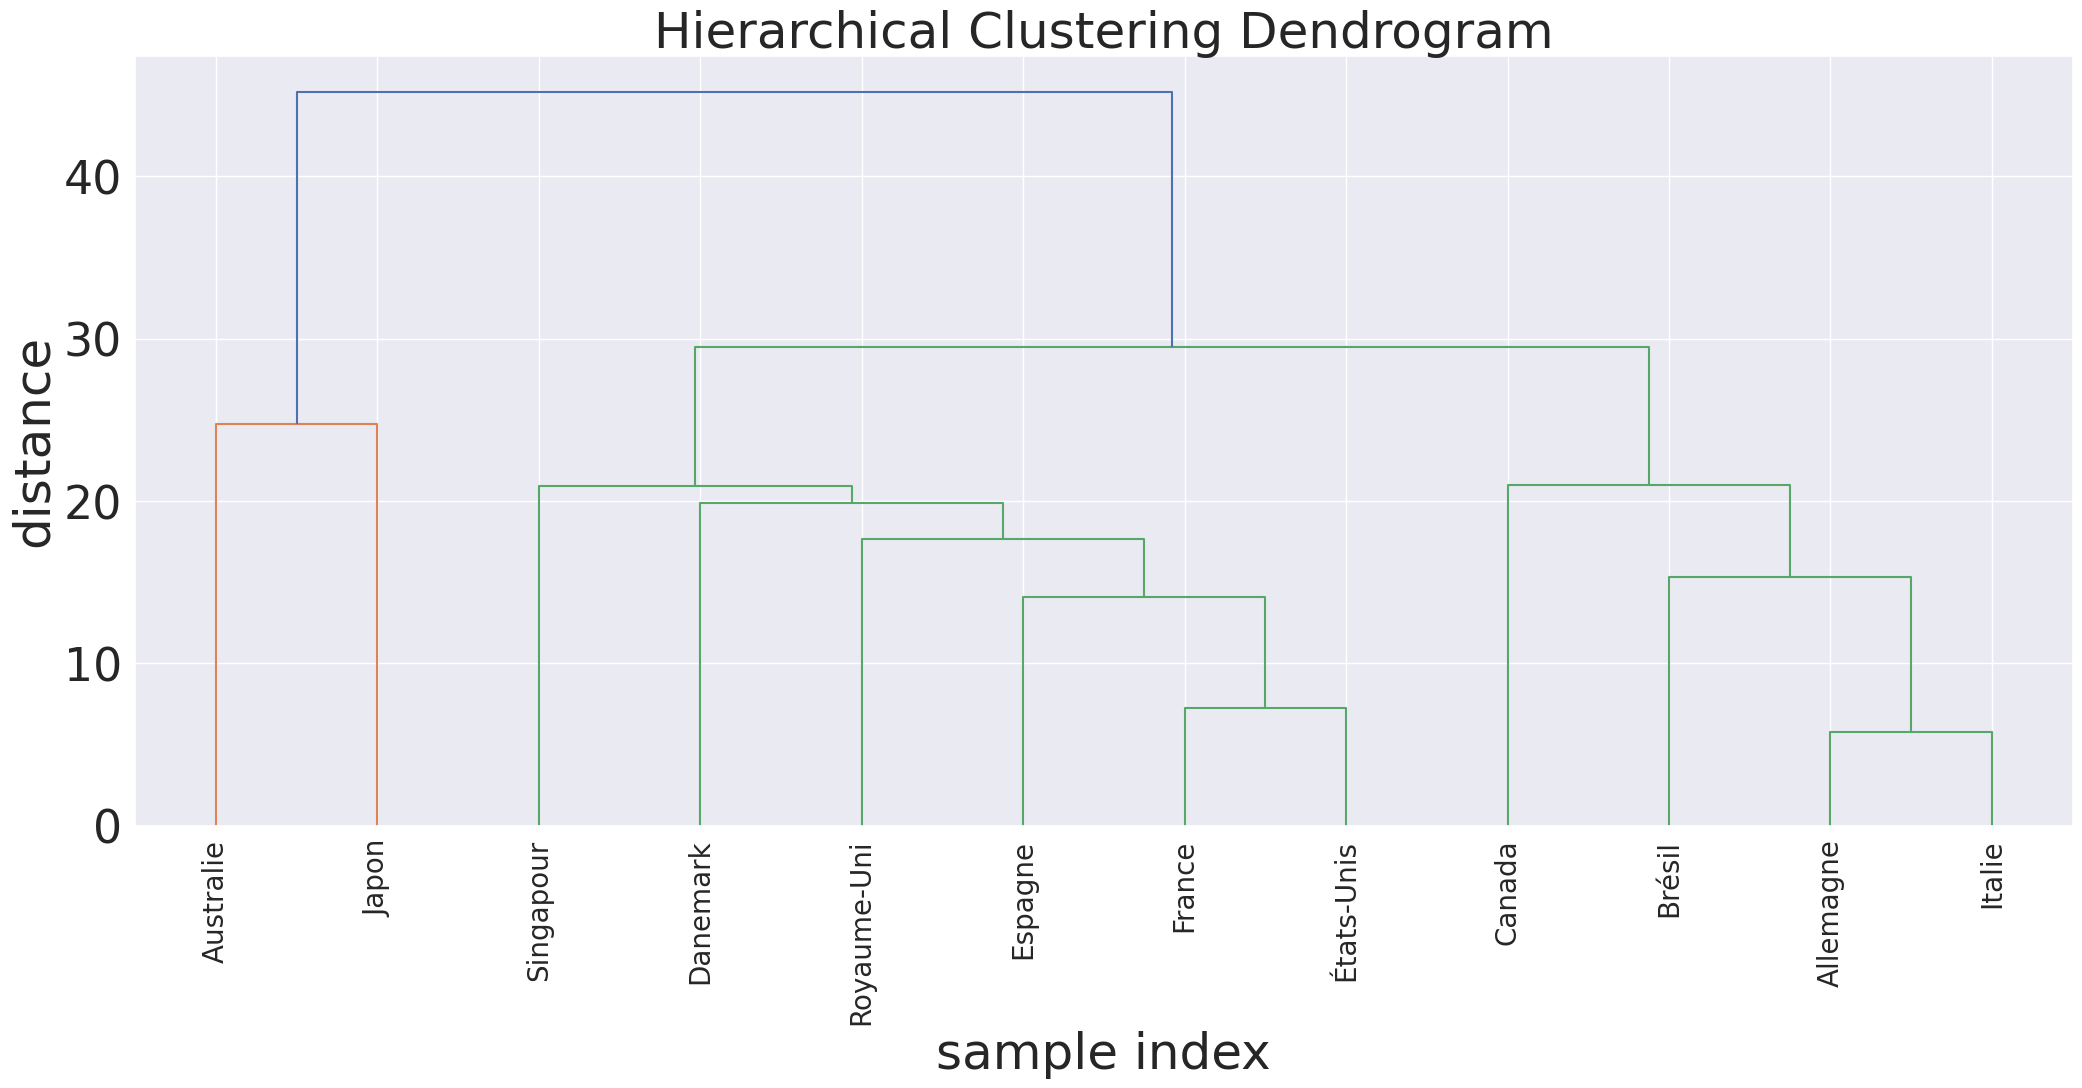

In [73]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram( Z,leaf_rotation=90.,leaf_font_size=20.,
           labels = d02.reset_index().pays.values)
plt.show()

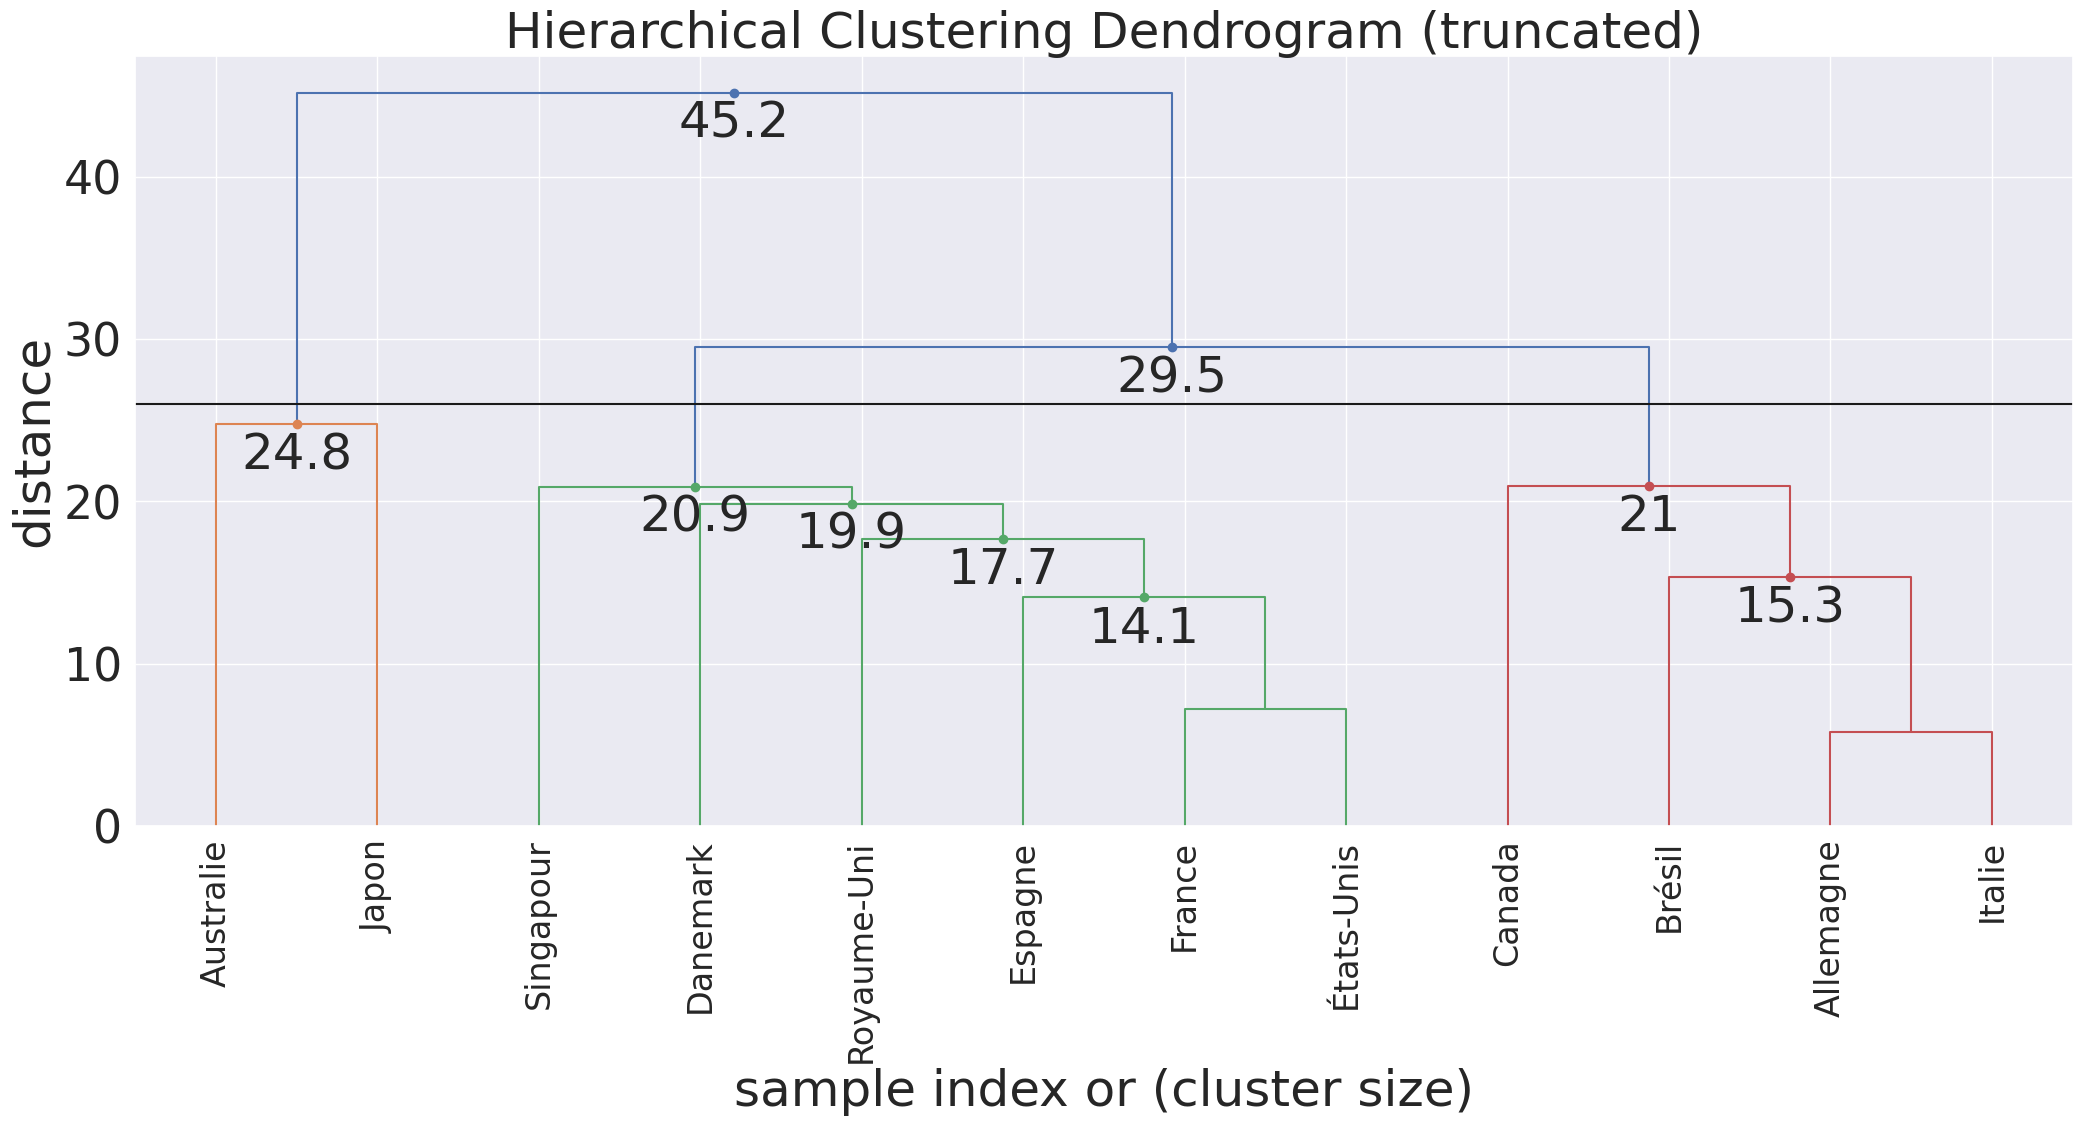

In [78]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    #p=12,
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=10,  
    max_d=26,
    labels = d02.reset_index().pays.values
)
plt.show()

In [80]:
from scipy.cluster.hierarchy import fcluster
d02['Classes3']=fcluster(Z, t=26, criterion='distance')
d02['Classe2']=fcluster(Z, t=35, criterion='distance')

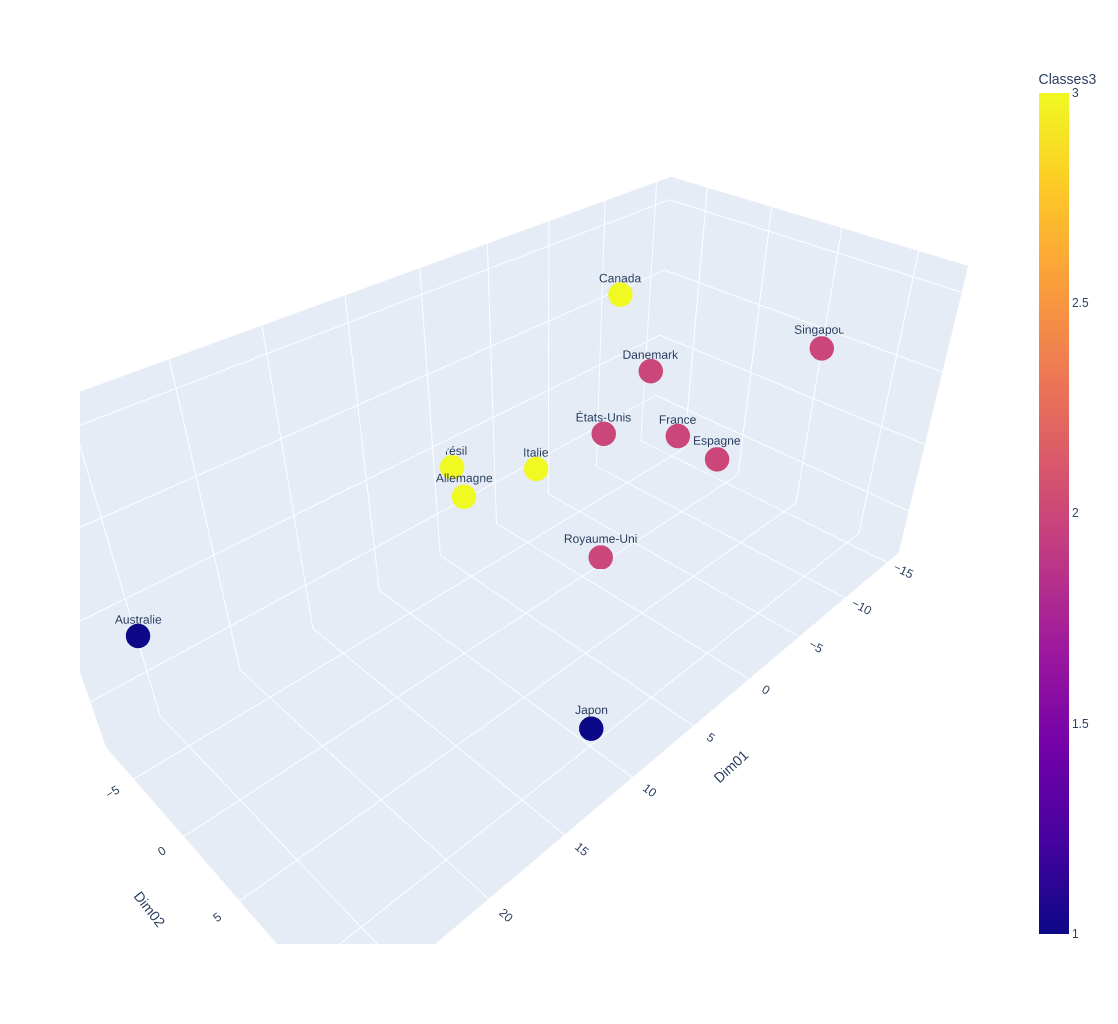

In [82]:
import plotly.express as px
fig = px.scatter_3d(d02.reset_index(), 
                    x='Dim01', 
                    y='Dim02', 
                    z='Dim03',
                    color='Classes3',
                    #size=np.abs(donnees.Eat),
                    #symbol='CD23',
                    text='pays', 
                    width=900,
                    height=1024,
                   )

fig.show()

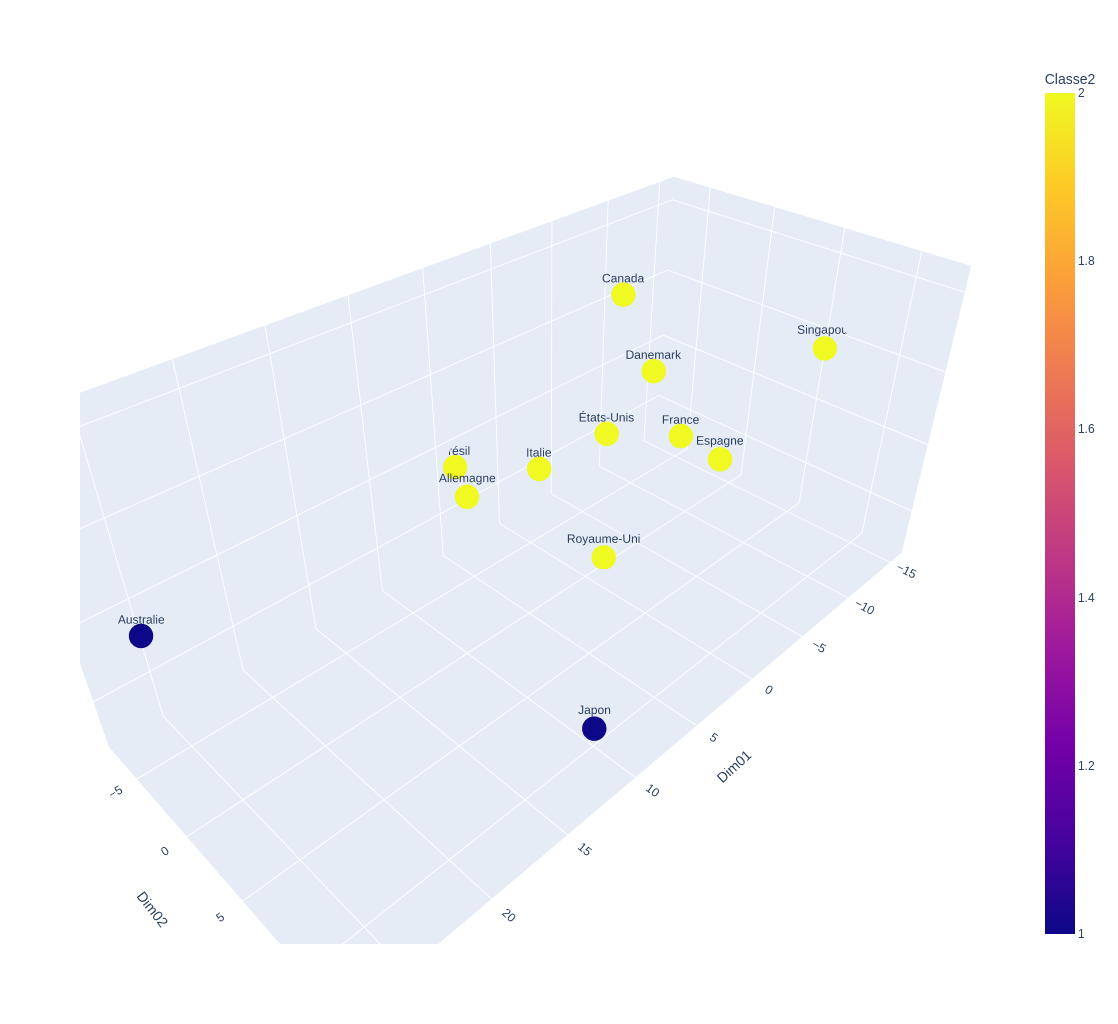

In [84]:
fig = px.scatter_3d(d02.reset_index(), 
                    x='Dim01', 
                    y='Dim02', 
                    z='Dim03',
                    color='Classe2',
                    #size=np.abs(donnees.Eat),
                    #symbol='CD23',
                    text='pays', 
                    width=900,
                    height=1024,
                   )

fig.show()

In [24]:
tabC = donnees.pivot_table(index='mois',columns='pays', values='quantites')
tabC.head()

pays,Allemagne,Australie,Brésil,Canada,Danemark,Espagne,France,Italie,Japon,Royaume-Uni,Singapour,États-Unis
mois,,,,,,,,,,,,
1,304.452675,425.442907,395.936000,199.238411,214.753927,166.753676,252.143247,310.227803,437.513514,344.526761,210.091429,257.275754
2,269.066748,371.310345,326.410828,295.218447,210.960452,204.052356,252.511416,270.128834,315.574766,223.307692,148.120000,239.401773
3,339.614967,398.977337,354.965839,175.035398,249.320000,276.118033,260.468333,348.482105,294.140541,294.210826,210.274194,310.638923
4,352.981779,540.395652,265.528701,301.934343,143.126437,250.392453,349.299013,330.823350,481.507042,269.474576,230.439655,281.846882
5,345.663254,493.682327,265.387701,243.144444,292.596154,303.854430,210.432432,300.470243,358.291480,305.559165,207.786127,290.613197


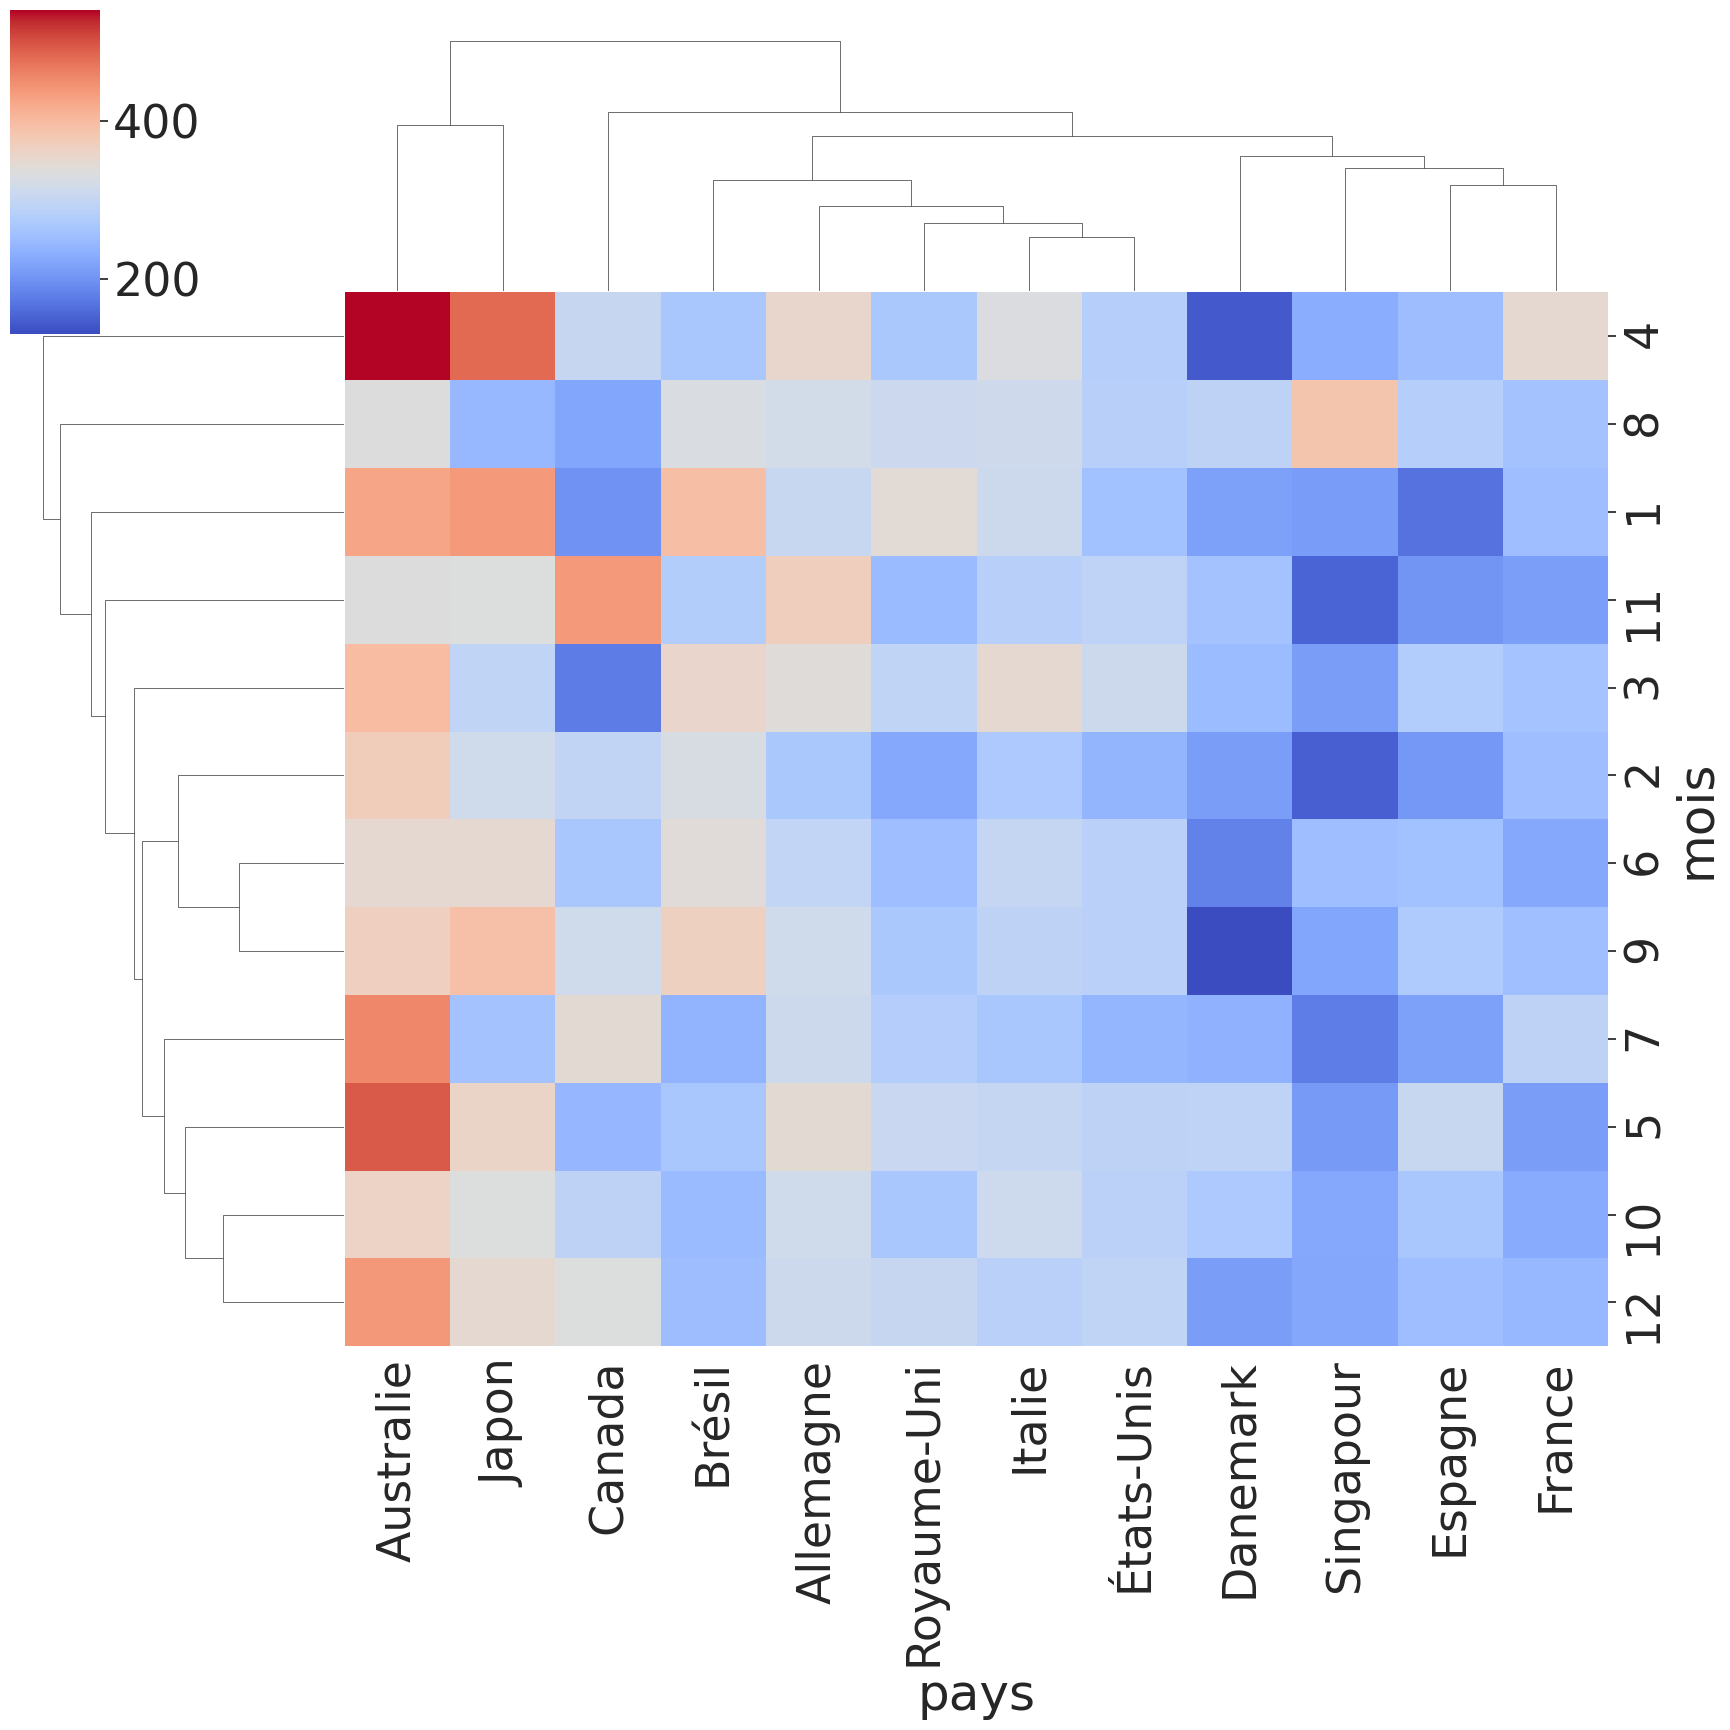

In [25]:
sns.clustermap(tabC.dropna(),cmap='coolwarm', figsize=(18,18));